**Thinkful - Challenge 2.5.2 - Validating Linear Regression**

In [23]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import sqrt
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels import regression
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
sns.set(style="white", context="talk")

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd")
 
#Read file and rename columns
df2 = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2014.csv')
df2 = df2.rename(columns={'Property crime': 'Property_crime'})
df2 = df2.rename(columns={'Murder and nonnegligent manslaughter': 'Murder'})
df2 = df2.rename(columns={'Larceny-theft': 'Larceny'})

#Create a copy of the dataframe with only the necessary columns
df = df2[['City', 'Population', 'Murder','Robbery','Larceny','Property_crime']].copy()

#Remove commas from numbers
df['Property_crime'] = df['Property_crime'].map(lambda x: ''.join(list(filter(str.isdigit, str(x)))))
df['Population'] = df['Population'].map(lambda x: ''.join(list(filter(str.isdigit, str(x)))))
df['Robbery'] = df['Robbery'].map(lambda x: ''.join(list(filter(str.isdigit, str(x)))))
df['Larceny'] = df['Larceny'].map(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

#Convert strings to integers and read into file
df['Population'] = list(map(int, df['Population']))
df['Robbery'] = list(map(int, df['Robbery']))
df['Property_crime'] = list(map(int, df['Property_crime']))
df['Murder'] = list(map(int, df['Murder']))
df['Larceny'] = list(map(int, df['Larceny']))

#Create variables
property_crime = df['Property_crime']
population = df['Population']
robbery = df['Robbery']
murder = df['Murder']
df.head()

,City,Population,Murder,Robbery,Larceny,Property_crime
0,Adams Village,1851,0,0,10,11
1,Addison Town and Village,2568,0,1,47,49
2,Afton Village,820,0,0,1,1
3,Akron Village,2842,0,0,17,17
4,Albany,98595,8,237,3083,3888


**Validation Model**

To validate my previous model, I used New York crime data from a different year (2014) to verify that the model is applicable on other datasets by using cross-validation with 10 groups.

In [24]:
#Create variable for murder per capita and append to dataframe
Murder_PerCap = []
for i in range(len(murder)):
    Murder_PerCap.append(murder[i]/population[i])
df['Murder_Per_Capita'] = pd.Series(Murder_PerCap, index=df.index)

#Create variable for robbery per capita and append to dataframe
Robbery_PerCap = []
for i in range(len(robbery)):
    Robbery_PerCap.append(robbery[i]/population[i])
df['Robbery_Per_Capita'] = pd.Series(Robbery_PerCap, index=df.index)

# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Property_crime ~ Population+Murder+Murder_Per_Capita+Robbery+Robbery_Per_Capita'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
print("Parameters:")
print(lm.params)
print(" ")
print("R-Squared:")
print(lm.rsquared)
print(" ")
print("Confidence Intervals:")
print(lm.conf_int())
print(" ")
pd.options.display.float_format = '{:.16f}'.format
print("P-values:")
print(lm.pvalues)

Parameters:
Intercept                 -39.561
Population                  0.017
Murder                    251.154
Murder_Per_Capita    -2450062.666
Robbery                    -5.659
Robbery_Per_Capita     276454.525
dtype: float64
 
R-Squared:
0.998710357246
 
Confidence Intervals:
                              0            1
Intercept               -75.363       -3.760
Population                0.015        0.019
Murder                  225.458      276.851
Murder_Per_Capita  -3408390.097 -1491735.236
Robbery                  -7.077       -4.241
Robbery_Per_Capita   223518.522   329390.527
 
P-values:
Intercept            0.0304219465992269
Population           0.0000000000000000
Murder               0.0000000000000000
Murder_Per_Capita    0.0000007817870339
Robbery              0.0000000000000482
Robbery_Per_Capita   0.0000000000000000
dtype: float64


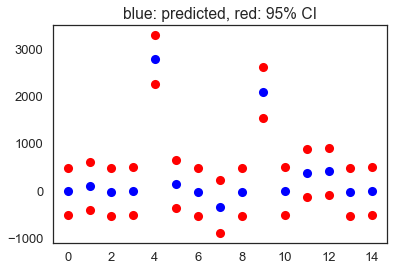

In [25]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

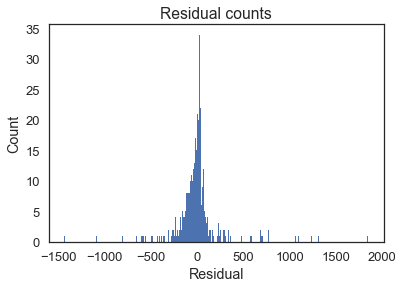

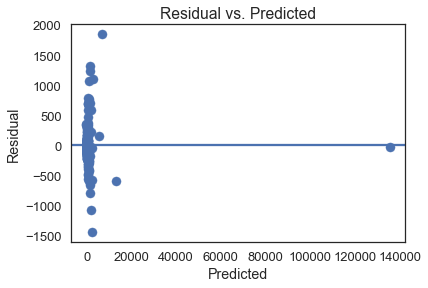

,Population,Murder,Murder_Per_Capita,Robbery,Robbery_Per_Capita
Population,1.000,0.985,0.065,0.998,0.166
Murder,0.985,1.000,0.150,0.993,0.253
Murder_Per_Capita,0.065,0.150,1.000,0.088,0.555
Robbery,0.998,0.993,0.088,1.000,0.196
Robbery_Per_Capita,0.166,0.253,0.555,0.196,1.000


In [26]:
pd.options.display.float_format = '{:.3f}'.format
#Instantiate and fit our model.
Y = df['Property_crime'].values.reshape(-1, 1)
X = df[['Population','Murder','Murder_Per_Capita','Robbery','Robbery_Per_Capita']]

########
#Evaluating multivariate normality
# Extract predicted values.
predicted = lm.predict(X).ravel()
actual = df['Property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted
abs_resid = abs(residual)
df['Absolute Residual'] = pd.Series(abs_resid, index=df.index)

binwidth = 10
plt.hist(residual, bins=np.arange(min(residual), max(residual) + binwidth, binwidth))
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#######
#Evaluating homoscedacity
df['Predicted'] = pd.Series(predicted, index=df.index)
df['Residual'] = pd.Series(residual, index=df.index)

#Plot all data
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

######
#Evaluating multicolinearity
correlation_matrix = X.corr()
display(correlation_matrix)

In [27]:
n = 0.1
linear_formula = 'Property_crime ~ Population+Murder+Murder_Per_Capita+Robbery+Robbery_Per_Capita'
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=n)
train_mode = smf.ols(linear_formula, data=X_train).fit()  
predictions = train_mode.predict(X_test).ravel() 
print(sklearn.metrics.r2_score(y_test,predictions))

0.738888565396


In [28]:
df.sort_values('Absolute Residual', ascending=False).head(10)

,City,Population,Murder,Robbery,Larceny,Property_crime,Murder_Per_Capita,Robbery_Per_Capita,Absolute Residual,Predicted,Residual
283,Rochester,210347,27,698,6058,8856,0.000,0.003,1848.058,7007.942,1848.058
147,Hempstead Village,55722,8,248,607,965,0.000,0.004,1437.109,2402.109,-1437.109
57,Cheektowaga Town,78209,1,66,2324,2699,0.000,0.001,1315.409,1383.591,1315.409
229,Niagara Falls,49300,3,161,1858,2641,0.000,0.003,1237.566,1403.434,1237.566
4,Albany,98595,8,237,3083,3888,0.000,0.002,1100.057,2787.943,1100.057
218,Mount Vernon,68442,6,195,695,1031,0.000,0.003,1081.459,2112.459,-1081.459
26,Binghamton,46229,1,82,1653,2048,0.000,0.002,1068.927,979.073,1068.927
279,Ramapo Town,88881,0,18,536,643,0.000,0.000,798.418,1441.418,-798.418
348,Watertown,28009,0,17,1097,1296,0.000,0.001,782.815,513.185,782.815
68,Colonie Town,78717,0,37,1786,2010,0.000,0.000,776.750,1233.250,776.750


**Model #1 - Old model using cross-validation with 20% holdout**
By validating using a 10% holdout, I found that the model was not consistently predictive. To verify this inconsistency, I performed a second cross-validation with 20% holdout.

In [29]:
n = 0.2
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=n)
train_mode = smf.ols(linear_formula, data=X_train).fit()  
predictions = train_mode.predict(X_test).ravel() 
print(sklearn.metrics.r2_score(y_test,predictions))

0.617508529249


**Model #2 - New model using cross-validation with 20 groups**
By validating with a 10% holdout and then with 20% holdout, I found that the model was not consistently predictive. To address this, I removed the parameters "murder per capita" and "robbery per capita" and replaced it with a "larceny" and "large city" category. Then, I cross-validated the model with a 20% holdout.

In [30]:
#Create Categorical Variable for large city data and append to dataframe
Large_City = []
for i in range(len(population)):
    if population[i]<30000:
        Large_City.append(0)
    elif population[i]<60000:
        Large_City.append(1)
    else:
        Large_City.append(2)
df['Large_City'] = pd.Series(Large_City, index=df.index)

# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Property_crime ~ Population+Murder+Robbery+Larceny+Large_City'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
print("Parameters:")
print(lm.params)
print(" ")
print("R-Squared:")
print(lm.rsquared)
print(" ")
print("Confidence Intervals:")
print(lm.conf_int())
print(" ")
pd.options.display.float_format = '{:.16f}'.format
print("P-values:")
print(lm.pvalues)

Parameters:
Intercept    21.403
Population   -0.004
Murder       26.678
Robbery       1.213
Larceny       1.216
Large_City   78.292
dtype: float64
 
R-Squared:
0.999946099748
 
Confidence Intervals:
                0      1
Intercept  14.937 27.869
Population -0.004 -0.003
Murder     20.112 33.245
Robbery     0.879  1.547
Larceny     1.190  1.241
Large_City 62.591 93.993
 
P-values:
Intercept    0.0000000002509510
Population   0.0000000000000000
Murder       0.0000000000000182
Robbery      0.0000000000050112
Larceny      0.0000000000000000
Large_City   0.0000000000000000
dtype: float64


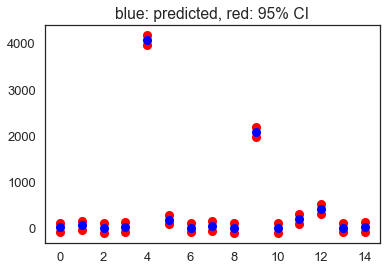

In [31]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

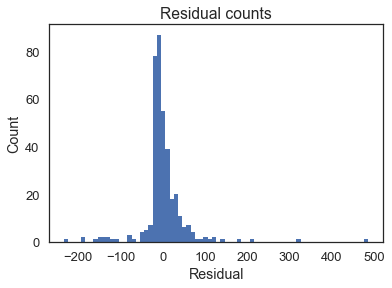

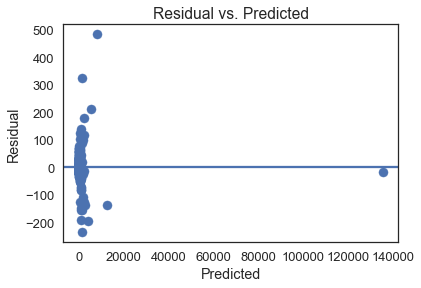

,Population,Murder,Robbery,Larceny,Large_City
Population,1.000,0.985,0.998,0.998,0.250
Murder,0.985,1.000,0.993,0.992,0.290
Robbery,0.998,0.993,1.000,0.999,0.252
Larceny,0.998,0.992,0.999,1.000,0.280
Large_City,0.250,0.290,0.252,0.280,1.000


In [32]:
pd.options.display.float_format = '{:.3f}'.format
#Instantiate and fit our model.
Y = df['Property_crime'].values.reshape(-1, 1)
X = df[['Population','Murder','Robbery','Larceny','Large_City']]

########
#Evaluating multivariate normality
# Extract predicted values.
predicted = lm.predict(X).ravel()
actual = df['Property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted
abs_resid = abs(residual)
df['Absolute Residual'] = pd.Series(abs_resid, index=df.index)

binwidth = 10
plt.hist(residual, bins=np.arange(min(residual), max(residual) + binwidth, binwidth))
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#######
#Evaluating homoscedacity
df['Predicted'] = pd.Series(predicted, index=df.index)
df['Residual'] = pd.Series(residual, index=df.index)

#Plot all data
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

######
#Evaluating multicolinearity
correlation_matrix = X.corr()
display(correlation_matrix)

In [33]:
n = 0.2
linear_formula = 'Property_crime ~ Population+Murder+Robbery+Larceny+Large_City'
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=n)
train_mode = smf.ols(linear_formula, data=X_train).fit()  
predictions = train_mode.predict(X_test).ravel() 
print(sklearn.metrics.r2_score(y_test,predictions))

0.996023439639


In [34]:
df.sort_values('Absolute Residual', ascending=False).head(10)

,City,Population,Murder,Robbery,Larceny,Property_crime,Murder_Per_Capita,Robbery_Per_Capita,Absolute Residual,Predicted,Residual,Large_City
283,Rochester,210347,27,698,6058,8856,0.000,0.003,483.792,8372.208,483.792,2
366,Yonkers,200624,3,358,1395,2009,0.000,0.002,323.883,1685.117,323.883,2
222,Newburgh Town,30826,1,13,1317,1401,0.000,0.000,234.101,1635.101,-234.101,1
326,Syracuse,144534,20,406,3986,5755,0.000,0.003,211.917,5543.083,211.917,2
4,Albany,98595,8,237,3083,3888,0.000,0.002,193.196,4081.196,-193.196,2
147,Hempstead Village,55722,8,248,607,965,0.000,0.004,191.599,1156.599,-191.599,1
229,Niagara Falls,49300,3,161,1858,2641,0.000,0.003,180.089,2460.911,180.089,1
138,Guilderland Town,33958,4,4,602,669,0.000,0.000,155.077,824.077,-155.077,1
275,Poughkeepsie Town,43599,0,30,1303,1414,0.000,0.001,153.270,1567.270,-153.270,1
218,Mount Vernon,68442,6,195,695,1031,0.000,0.003,148.646,1179.646,-148.646,2
